In [12]:
## import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import json

# import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# initialize a Spark session
driver_memory = "200g"
executor_memory = "10g"
n_executors = 20 - 1

spark = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                            .config("spark.executor.memory", executor_memory) \
                            .config("spark.executor.instances", n_executors) \
                            .getOrCreate()

In [3]:
%%time
### Load datasets
df_type = 30

### Open the preprocessed dataset
df_filtered = spark.read.load("preprocessed_df_subset/preprocessed_df_subset.parquet")
# df_count = df.count()

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = spark.read.csv(meta_filename, inferSchema=True, header=True)
# df_meta_count = df_meta.count()

# load labeled anomalies from subset
labeled_anomalies = spark.read.csv("preprocessed_df_subset/pca_major_outliers.csv", header=True, inferSchema=True)

# load new dataset with outliers
outliers = spark.read.csv("outliers/4_iforest_outliers.csv", header=True, inferSchema=True)

# calculate Q1 and Q3
q1 = outliers.approxQuantile("score", [0.25], 0.01)[0]
q3 = outliers.approxQuantile("score", [0.75], 0.01)[0]

# calculate IQR
iqr = q3 - q1

# calculate cutoff
cutoff = q1 - 1.5 * iqr

# apply cutoff to the outliers
manual_cutoff = 0.746
outliers_filtered = outliers.filter(F.col("score") < manual_cutoff)

# convert metadata to pandas
df_meta = df_meta.toPandas()

CPU times: user 91.3 ms, sys: 5.75 ms, total: 97 ms
Wall time: 6.03 s


In [4]:
labeled_anomalies.show()

+---+------------+-----+----------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|_c0|          id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|            recon_PC|          recon_PC1|          recon_PC2|            power_PC|          power_PC1|          power_PC2|
+---+------------+-----+----------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|  0| 34359900110|11166|2017-10-19|[0.0, 0.0, 0.0, 0...|[0.52697645820444...|[-22358.707756119...|[123025.026370795...| 123025.02637079507| 11108.464198530139|[-7102.0403566638...|  -7102.04035666388|-11178.457952697754|
|  1|146029336759| 7635|2017-12-02|[0.0, 0.0, 0.0, 0...|[0.64951905282214...|[17884.5246535117...|[-56668.839213105.

In [6]:
# rename columns
labeled_anomalies = labeled_anomalies.withColumnRenamed("ss_id", "anomaly_ss_id") \
                                     .withColumnRenamed("stamp_date", "anomaly_stamp_date") \
                                     .withColumnRenamed("power_kW_values", "anomaly_power_kW_values") \
                                     .withColumnRenamed("coefficients", "anomaly_coeff") \
                                     .withColumnRenamed("reconstructions", "anomaly_recon") \
                                     .withColumnRenamed("recon_PC", "anomaly_recon_PC") \
                                     .withColumnRenamed("recon_PC1", "anomaly_recon_PC1") \
                                     .withColumnRenamed("recon_PC2", "anomaly_recon_PC2") \
                                     .withColumnRenamed("power_PC", "anomaly_power_PC") \
                                     .withColumnRenamed("power_PC1", "anomaly_power_PC1") \
                                     .withColumnRenamed("power_power_PC2", "anomaly_power_PC2") \

# rename columns
outliers_filtered = outliers_filtered.withColumnRenamed("ss_id", "outlier_ss_id") \
                                     .withColumnRenamed("id", "outlier_id") \
                                     .withColumnRenamed("stamp_date", "outlier_stamp_date") \
                                     .withColumnRenamed("score", "outlier_score")

# ensure the original dataframe does not have duplicated column names
df_filtered = df_filtered.withColumnRenamed("id", "original_id") \
                         .withColumnRenamed("ss_id", "original_ss_id") \
                         .withColumnRenamed("stamp_date", "original_stamp_date") \
                         .withColumnRenamed("power_kW_values", "original_power_kW_values") \
                         .withColumnRenamed("coefficients", "original_coefficients") \
                         .withColumnRenamed("reconstructions", "original_reconstructions") \
                         .withColumnRenamed("recon_PC", "original_recon_PC") \
                         .withColumnRenamed("recon_PC1", "original_recon_PC1") \
                         .withColumnRenamed("recon_PC2", "original_recon_PC2") \
                         .withColumnRenamed("power_PC", "original_power_PC") \
                         .withColumnRenamed("power_PC1", "original_power_PC1") \
                         .withColumnRenamed("power_PC2", "original_power_PC2") \

# sample a smaller portion of the data first to reduce load
print("Sampling the data...")
sampled_data = df_filtered.sample(withReplacement=False, fraction=0.1, seed=24)
sampled_data.count()

# merge labeled anomalies with the original dataframe
labeled_data = sampled_data.join(labeled_anomalies, sampled_data.original_ss_id == labeled_anomalies.anomaly_ss_id, how="left")

# merge filtered outliers with the labeled data
labeled_data = labeled_data.join(outliers_filtered, labeled_data.original_ss_id == outliers_filtered.outlier_ss_id, how="left")

# create a label column where 1 indicates an anomaly and 0 indicates normal
labeled_data = labeled_data.withColumn("label", F.when((F.col("anomaly_ss_id").isNotNull()) | (F.col("outlier_ss_id").isNotNull()), 1).otherwise(0))

# print schema to verify column names
labeled_data.printSchema()

Sampling the data...
root
 |-- original_id: long (nullable = true)
 |-- original_ss_id: long (nullable = true)
 |-- original_stamp_date: date (nullable = true)
 |-- original_power_kW_values: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- original_coefficients: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- original_reconstructions: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- original_recon_PC: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- original_recon_PC1: double (nullable = true)
 |-- original_recon_PC2: double (nullable = true)
 |-- original_power_PC: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- original_power_PC1: double (nullable = true)
 |-- original_power_PC2: double (nullable = true)
 |-- _c0: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- anomaly_ss_id: integer (nullable = true)
 |-- anomaly_stamp_date: dat

In [7]:
labeled_anomalies.show(3)

+---+------------+-------------+------------------+-----------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+
|_c0|          id|anomaly_ss_id|anomaly_stamp_date|anomaly_power_kW_values|       anomaly_coeff|       anomaly_recon|    anomaly_recon_PC|  anomaly_recon_PC1| anomaly_recon_PC2|    anomaly_power_PC|  anomaly_power_PC1|          power_PC2|
+---+------------+-------------+------------------+-----------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+
|  0| 34359900110|        11166|        2017-10-19|   [0.0, 0.0, 0.0, 0...|[0.52697645820444...|[-22358.707756119...|[123025.026370795...| 123025.02637079507|11108.464198530139|[-7102.0403566638...|  -7102.04035666388|-11178.457952697754|
|  1|146029336759|         7635|        2017

In [8]:
labeled_data.show(5)

+-----------+--------------+-------------------+------------------------+---------------------+------------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+----+----+-------------+------------------+-----------------------+-------------+-------------+----------------+-----------------+-----------------+----------------+-----------------+---------+-----+------------+-------------+------------------+------------------+-----+
|original_id|original_ss_id|original_stamp_date|original_power_kW_values|original_coefficients|original_reconstructions|   original_recon_PC| original_recon_PC1|  original_recon_PC2|   original_power_PC| original_power_PC1|  original_power_PC2| _c0|  id|anomaly_ss_id|anomaly_stamp_date|anomaly_power_kW_values|anomaly_coeff|anomaly_recon|anomaly_recon_PC|anomaly_recon_PC1|anomaly_recon_PC2|anomaly_power_PC|anomaly_power_PC1|power_PC2|  _c0|  outlier_id|outlier_ss_id|outlier_stamp_d

In [9]:
spark.catalog.clearCache()

# define a UDF to convert strings to arrays
def string_to_array(value):
    if isinstance(value, list):
        return value
    if value is None:
        return []
    return [float(x) for x in value.strip('[]').split(',')]

string_to_array_udf = udf(string_to_array, ArrayType(DoubleType()))

# apply the UDF to convert string columns to array columns
labeled_data = labeled_data.withColumn("reconstructions_array", string_to_array_udf(F.col("original_reconstructions"))) \

labeled_data = labeled_data.filter(F.size(F.col("reconstructions_array")) > 0)

# convert arrays to vectors
def array_to_vector(array):
    return Vectors.dense(array)

array_to_vector_udf = udf(array_to_vector, VectorUDT())

# apply UDF to convert arrays to vectors
labeled_data = labeled_data.withColumn("reconstructions_vector", array_to_vector_udf(F.col("reconstructions_array"))) \

# assemble the vectors into a single feature vector
assembler = VectorAssembler(inputCols=["reconstructions_vector", "original_recon_PC1", "original_recon_PC2"], outputCol="features")
final_data = assembler.transform(labeled_data)

# select only the features and label columns
final_data = final_data.select("features", "label")

def is_vector_empty(vector):
    return len(vector.values) == 0

is_vector_empty_udf = udf(is_vector_empty, BooleanType())

non_empty_data = final_data.filter(~is_vector_empty_udf(F.col("features")))
empty_data = final_data.filter(is_vector_empty_udf(F.col("features")))

In [10]:
# check the label distribution
label_distribution = final_data.groupBy("label").count()
label_distribution.show()

+-----+---------+
|label|    count|
+-----+---------+
|    1|428697205|
|    0|   316713|
+-----+---------+



In [13]:
# sample a small fraction of the data to estimate class distribution
sample_fraction = 0.01
sampled_data = non_empty_data.sample(withReplacement=False, fraction=sample_fraction, seed=42)
sampled_label_distribution = sampled_data.groupBy("label").count().collect()

# estimate class counts from the sample
minority_class_count = next(row["count"] for row in sampled_label_distribution if row["label"] == 0)
majority_class_count = next(row["count"] for row in sampled_label_distribution if row["label"] == 1)

# calculate the sampling fraction for down-sampling the majority class
sampling_fraction = minority_class_count / float(majority_class_count)

# down-sample the majority class based on the estimated fraction
majority_class_data = non_empty_data.filter(col("label") == 1)
minority_class_data = non_empty_data.filter(col("label") == 0)

sampled_majority_class_data = majority_class_data.sample(withReplacement=False, fraction=sampling_fraction, seed=42)
balanced_data = sampled_majority_class_data.union(minority_class_data)

print("Count of balanced data:")
balanced_data.groupBy("label").count().show()

Count of balanced data:
+-----+------+
|label| count|
+-----+------+
|    1|309550|
|    0|309845|
+-----+------+



In [15]:
balanced_data.write.mode("overwrite").parquet("balanced_data.parquet")

In [16]:
# split the sampled data into training and test sets
print("Splitting the data into training and test sets...")
train_data, test_data = balanced_data.randomSplit([0.8, 0.2], seed=30)
print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Splitting the data into training and test sets...
Training data count: 495437
Test data count: 123958


In [17]:
# define the Logistic Regression model
print("Defining the Logistic Regression model...")
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# create a ParamGrid for Cross Validation
print("Creating a ParamGrid for Cross Validation...")
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# define the Binary Classification Evaluator
print("Defining the Binary Classification Evaluator...")
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")

# create 5-fold CrossValidator
print("Creating 5-fold CrossValidator...")
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

Defining the Logistic Regression model...
Creating a ParamGrid for Cross Validation...
Defining the Binary Classification Evaluator...
Creating 5-fold CrossValidator...


In [18]:
# train the model
print("Training the model...")
cvModel = cv.fit(train_data)
print("Model training completed.")

# make predictions on the test data
print("Making predictions on the test data...")
predictions = cvModel.transform(test_data)
print("Predictions completed.")

# evaluate the model
print("Evaluating the model...")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# show some predictions
print("Showing some predictions...")
predictions.select("features", "label", "prediction", "probability").show(5)
print("Prediction display completed.")

Training the model...
Model training completed.
Making predictions on the test data...
Predictions completed.
Evaluating the model...
Test Accuracy: 0.7019551086538586
Showing some predictions...
+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|[-0.0795934026130...|    1|       1.0|[0.34258434094150...|
|[-0.0778390198141...|    1|       1.0|[0.35558051224536...|
|[-0.0717546962004...|    1|       1.0|[0.37771346112595...|
|[-0.0665710082629...|    1|       1.0|[0.16257928493434...|
|[-0.0630834299270...|    1|       1.0|[0.15732504297349...|
+--------------------+-----+----------+--------------------+
only showing top 5 rows

Prediction display completed.


In [19]:
# create a confusion matrix
predictions.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|26477|
|    1|       1.0|35354|
|    0|       0.0|45500|
|    0|       1.0|16627|
+-----+----------+-----+



In [24]:
# save the trained model
cvModel.save("logistic_reg_model/model")

# save the predictions
predictions.write.format("parquet").save("logistic_reg_model/predictions")

# save the evaluation metrics
metrics = {
    "accuracy": accuracy
}

with open("logistic_reg_model/metrics.json", "w") as f:
    json.dump(metrics, f)

weighted precision: 0.6560824589207148
weighted recall: 0.6522693170267349
f1 score: 0.6499924151512801


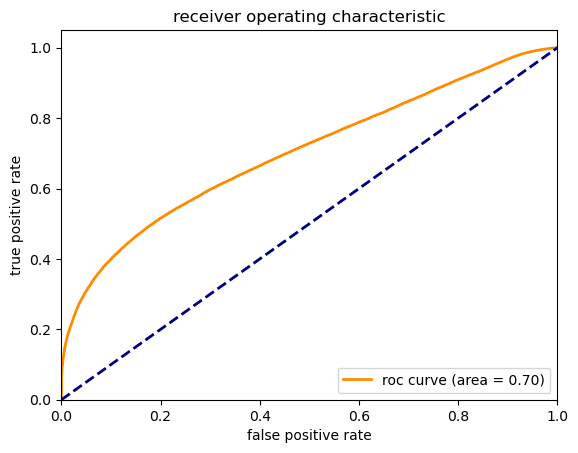

In [25]:
# additional metrics
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"weighted precision: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"weighted recall: {recall}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)
print(f"f1 score: {f1}")

metrics.update({
    "precision": precision,
    "recall": recall,
    "f1": f1
})

with open("logistic_reg_model/metrics.json", "w") as f:
    json.dump(metrics, f)

# roc and auc
predictions_pd = predictions.select("label", "probability").toPandas()
fpr, tpr, _ = roc_curve(predictions_pd["label"], predictions_pd["probability"].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='roc curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("logistic_reg_model/roc_curve.png")

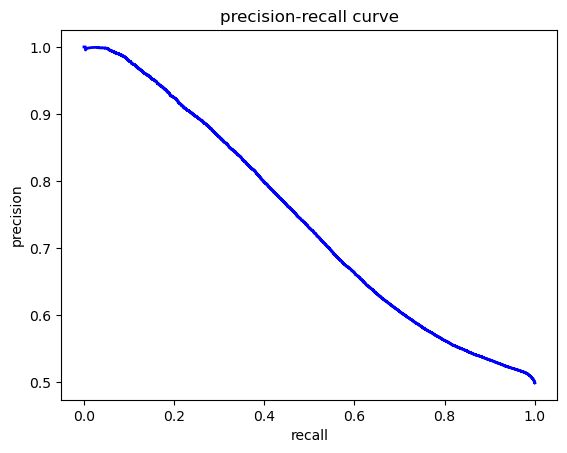

In [26]:
# precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(predictions_pd["label"], predictions_pd["probability"].apply(lambda x: x[1]))
plt.figure()
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')
plt.savefig("logistic_reg_model/precision_recall_curve.png")

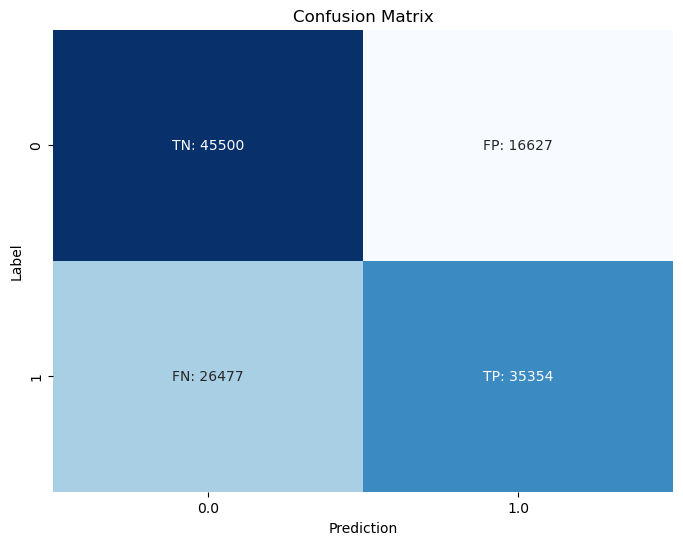

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

confusion_data = {
    'label': [1, 1, 0, 0],
    'prediction': [0.0, 1.0, 0.0, 1.0],
    'count': [26477, 35354, 45500, 16627]
}

df_confusion = pd.DataFrame(confusion_data)

# pivot data to create the confusion matrix
confusion_matrix = df_confusion.pivot(index='label', columns='prediction', values='count')

# annotate the confusion matrix with TP, TN, FP, FN labels
confusion_matrix_annotated = confusion_matrix.copy()
confusion_matrix_annotated.iloc[0, 0] = f"TN: {confusion_matrix.iloc[0, 0]}"
confusion_matrix_annotated.iloc[0, 1] = f"FP: {confusion_matrix.iloc[0, 1]}"
confusion_matrix_annotated.iloc[1, 0] = f"FN: {confusion_matrix.iloc[1, 0]}"
confusion_matrix_annotated.iloc[1, 1] = f"TP: {confusion_matrix.iloc[1, 1]}"

# plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=confusion_matrix_annotated, fmt="", cmap="Blues", cbar=False)

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.savefig("logistic_reg_model/confusion_matrix.png")